# Risk & Uncertainty Assessment of a region facing tropcial cyclones

## CLIMADA exercise to the lecture
### Climate Change Uncertainty and Risk: from Probabilistic Forecasts to Economics of Climate Adaptation

**Prof. Reto Knutti and Prof. David Bresch** <br>
Spring Term 2022<br>
<br>
**Tutors**<br>
Liviana Klein (liviana.klein@env.ethz.ch<br>
Marius Egli (marius.egli@env.ethz.ch<br>
Simona Meiler (simona.meiler@usys.ethz.ch)<br>
Samuel Lüthi (samuel.luethi@usys.ethz.ch)<br>
Zélie Stalhandske (zelie.stalhandske@usys.ethz.ch)<br>


All relevant course information to be found here:<br>
http://www.iac.ethz.ch/edu/courses/master/modules/climate-risk.html<br>
Everything for CLIMADA (tutorials, code) can be downloaded from GitHub:<br>
https://github.com/CLIMADA-project/climada_python

## Introduction: Understand the probabilistic natural catastrophe impact model CLIMADA
The goal of this exercise is to get acquainted with the probabilistic natural catastrophe impact model CLIMADA. A set of exercises will walk you through the single steps of a standard impact calculation. This process includes using the CLIMADA tropical cylone model to calculate windfields, load exposure data, apply impact functions, and calculate impacts. You will use this framework to explore and discuss a set of questions around how to derive economics of climate change adaptation, how to think about uncertainty, how to implement climate change. We encourage you to experiment and explore. Once you have worked your way through these exercises you should be able to apply CLIMADA to your own project, which you may present at the end of this course. <br>

**The functionality of CLIMADA is gathered in the following classes:**
- **Entity**: socio-economic models:
   - Exposures: exposed values
      - BlackMarble: regional economic model from nightlight intensities and economic indicators (GDP, income group)
      - LitPop: regional economic model using nightlight and population maps together with several economic indicators
   - ImpactFuncSet: collection of impact functions per hazard
      - ImpactFunc: one adjustable impact function
      - IFTropCyclone: definition of impact functions for tropical cyclones
   - DiscRates: discount rates per year
   - MeasureSet: collection of measures for adaptation
      - Measure: one configurable measure
- **Hazard**: meteorological models:
   - TropCyclone: tropical cyclone events
- **Impact**: impacts of the Hazard and Entity interaction.
- **CostBenefit**: adaptation options appraisal.
- **Add-ons**: OpenStreetMap and Google Earth Engine routines.

Classes provide a means of bundling data and functionality together.

**Outline exercises**
1. Hazard calculation
2. Exposure creation, Vulnerability, Impact calculation, Dealing with uncertainty, Effect of insurance, Discounting and Cost-Benefit Analysis
3. Climate Change Scenarios, Economic Growth and Total Climate Risk

**Expected deliverables:**<br>
* A Jupyter Notebook file for all your code. Use markdown blocks to specify the question and code blocks to calculate and plot the answers. Please provide the excel files as well.
* A pdf-dump of the calculated Jupyter Notebook.<br>

**Cautionary remarks and further notes:**<br>
* The execution of some cells is computationally demanding and takes some time. We indicate these cells with a small note. Particularly, the generation of the hazard event set takes **> 10 minutes**.
* Some commands generate (a long set of) **WARNINGS**. These are not **ERRORS** and thus of no further concern beyond a little bit of annoying output.
* For some questions or tasks we ask you to inspect classes or functions. For those who are less familiar with the object-oriented style of programming in Python, the following hints might prove useful: First, you can always use **`help(function or class`)** to print out information of the class or functions you'd like to inspect. Second, following magic command opens an IPython Console that allows you to explore your code:

In [90]:
%qtconsole

## 1. Generate hazard event set

In this part we will create the hazard event set describing the intensity of tropical cyclones in Taiwan (Western Pacific). In CLIMADA the class `hazard` and, more specifically, the derived class `TropCyclone` are defined to hold all information of this natural forcing. Before we can create the hazard event set, we will look at the underlying information: the tracks of tropical cyclones which are organised in the class `TCTracks`. <br>
See the step-by-step tutorial to create a hazard event set in this tutorial: https://climada-python.readthedocs.io/en/latest/tutorial/climada_hazard_TropCyclone.html

### Load all needed modules
Use the following code to load all modules needed to generate the hazard event set, you can load more modules if you need them:

In [91]:
from climada.hazard import TCTracks, Centroids, TropCyclone
import numpy as np

Create a folder to store data you generate throughout the exercise. We suggest you name it "data" and store it on your IAC Hub.

In [92]:
from pathlib import Path
data_dir = Path('IAC_lectures/2022_FS/CCUR/Groupwork/data_climada')

### Read the storm track data
Use the following commands to read the storm track data of the International Best Track Archive for Climate Stewardship (IBTrACS). The command loads the storm named Herb with storm ID '1996203N12152' in the IBTrACS databse. Please refer to the tutorial for more details. <br>
Run the following code:

2022-06-08 16:59:02,631 - climada.hazard.tc_tracks - WARNING - The use of TCTracks.read_ibtracs_netcdf is deprecated. Use TCTracks.from_ibtracs_netcdf instead.


<GeoAxesSubplot:>

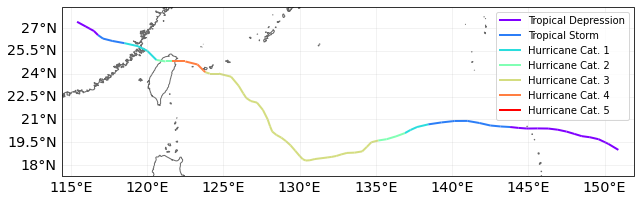

In [93]:
tr_herb = TCTracks()
tr_herb.read_ibtracs_netcdf(storm_id='1996203N12152')
tr_herb.plot()

If you have not yet downloaded the IBTrACS database, CLIMADA will try to do it for you automatically. If downloading it automatically does not work, CLIMADA will ask you to download the file yourself. The argument storm_id will select one storm to be read from the file. The third line makes CLIMADA generate a standard plot for the storm data. Look at the plot, check if it is reasonable, and examine tr_herb.data.<br>
Now read all tracks since 1990 for the Western Pacific with the following code:

2022-06-08 17:00:05,211 - climada.hazard.tc_tracks - WARNING - The use of TCTracks.read_ibtracs_netcdf is deprecated. Use TCTracks.from_ibtracs_netcdf instead.
2022-06-08 17:01:26,585 - climada.hazard.tc_tracks - WARNING - 61 storm events are discarded because no valid wind/pressure values have been found: 1990175N29122, 1990237N13142, 1991223N19162, 1991300N06149, 1992211N39164, ...
2022-06-08 17:01:26,595 - climada.hazard.tc_tracks - WARNING - 2 storm events are discarded because only one valid timestep has been found: 1996318N33146, 2004327N16125.


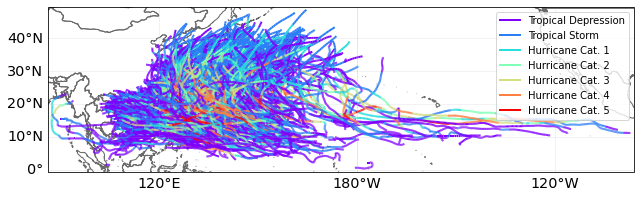

In [94]:
tracks_WP = TCTracks()
tracks_WP.read_ibtracs_netcdf(year_range=(1990, 2020), basin='WP')
tracks_WP.equal_timestep(time_step_h=1) 
tracks_WP.plot();

In [75]:
categories = [tracks_WP.data[i].category for i in range(len(tracks_WP.data))]
cat = set(categories)

for c in cat:
    print(c, categories.count(c))

0 285
1 83
2 94
3 83
4 124
5 40
-1 270


### Generate a probabilistic set
To account for uncertainty within the storm set, we add a number of perturbed storm tracks to those already stored in tracks_WP. We use a random walk procedure to generate a number of additional storms originating from the observed tracks. Note, that prior to generating probabilistic storms, we need to interpolate the data between the recorded time points and generate smooth tracks. The following line allows generating probabilistic storms:

<GeoAxesSubplot:>

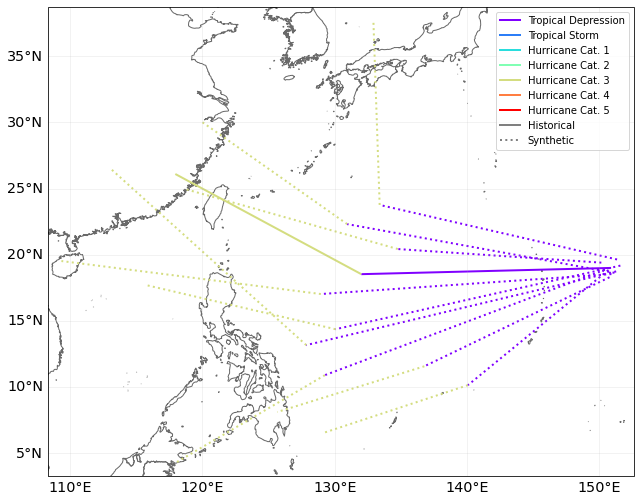

In [76]:
tr_herb.equal_timestep(time_step_h=100)
tr_herb.calc_perturbed_trajectories(nb_synth_tracks=9,max_shift_ini=0.75,max_dspeed_rel=0.3)
tr_herb.plot()

<GeoAxesSubplot:>

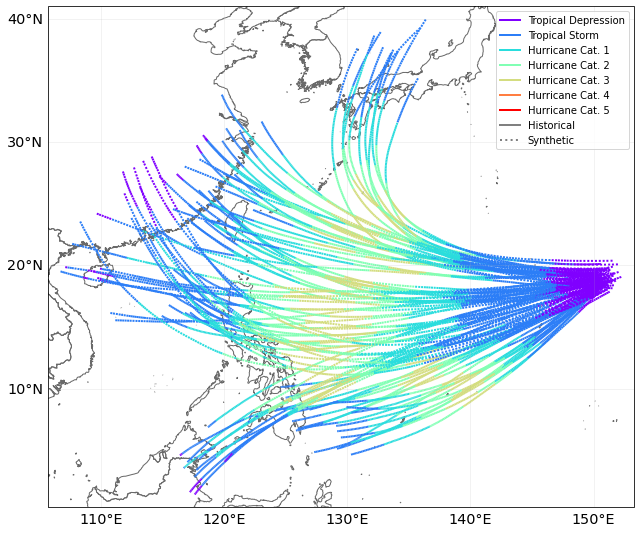

In [77]:
tr_herb.equal_timestep(time_step_h=1)
tr_herb.calc_perturbed_trajectories(nb_synth_tracks=9,max_shift_ini=0.75,max_dspeed_rel=0.3)
tr_herb.plot()

The variable "nb_synth_tracks" deﬁnes the number of probabilistic storms computed for each original storm loaded from the data . Additionally, we can specify further parameters (e.g. "max_shift_ini", "max_dspeed_rel") which are used by the random walk methodology.

You can view the CLIMADA module named `tc_tracks_synth` which contains the function `calc_perturbed_trajectories` with the following command:

In [78]:
from climada.hazard import tc_tracks_synth
help(tc_tracks_synth)

Help on module climada.hazard.tc_tracks_synth in climada.hazard:

NAME
    climada.hazard.tc_tracks_synth - This file is part of CLIMADA.

DESCRIPTION
    Copyright (C) 2017 ETH Zurich, CLIMADA contributors listed in AUTHORS.
    
    CLIMADA is free software: you can redistribute it and/or modify it under the
    terms of the GNU General Public License as published by the Free
    Software Foundation, version 3.
    
    CLIMADA is distributed in the hope that it will be useful, but WITHOUT ANY
    WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
    PARTICULAR PURPOSE.  See the GNU General Public License for more details.
    
    You should have received a copy of the GNU General Public License along
    with CLIMADA. If not, see <https://www.gnu.org/licenses/>.
    
    ---
    
    Generate synthetic tropical cyclone tracks from real ones

FUNCTIONS
    calc_perturbed_trajectories(tracks, nb_synth_tracks=9, max_shift_ini=0.75, max_dspeed_rel=0.3, max

**Tasks:**
* Explore the `calc_perturbed_trajectories` function by running a small sensitivity analysis. Test the sensitivity of the parameter choice on the generated storms by choosing different values for max_shift_ini and max_ddirection. You can simply alter the values in the argument of the command.
* Choose a parameter set which seems reasonable to you and decide on the number of random walks per storm (nb_synth_tracks). Generate the track set for all tracks by using the routine calc_perturbed_trajectories on tracks_WP.
* Note, there are some entries in the IBTrACS dataset that only contain one datapoint. We cannot apply the random walk algorithm to these entries and thus filter them out with the following routine before proceeding with the tasks.
* Second note, we will compare the probabilistic track set to the original data in exercise 2. We therefore suggest that you deepcopy the tracks_WP and apply the `calc_perturbed_trajectories` function to the copied track set. At the end of this exercise we'll show you how to save both hazard sets so that you can use them easily in the next block.

In [79]:
filter_only_one_time = [track for track in tracks_WP.data if track.time.size >= 2]
tracks_WP = TCTracks()
tracks_WP.data = filter_only_one_time

[ 0.5 10. ]
[0.01745329 0.00981748 0.00682955]
2022-06-08 16:35:02,993 - climada.hazard.tc_tracks - WARNING - The use of TCTracks.read_ibtracs_netcdf is deprecated. Use TCTracks.from_ibtracs_netcdf instead.
calc done
2022-06-08 16:35:07,085 - climada.hazard.tc_tracks - WARNING - The use of TCTracks.read_ibtracs_netcdf is deprecated. Use TCTracks.from_ibtracs_netcdf instead.
calc done
2022-06-08 16:35:11,094 - climada.hazard.tc_tracks - WARNING - The use of TCTracks.read_ibtracs_netcdf is deprecated. Use TCTracks.from_ibtracs_netcdf instead.
calc done


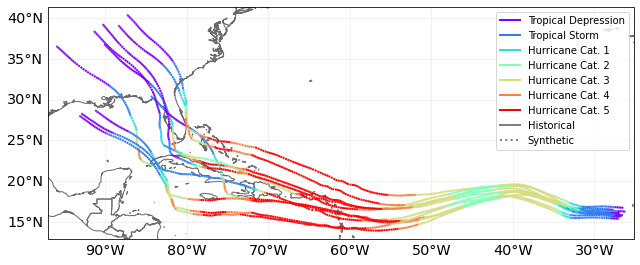

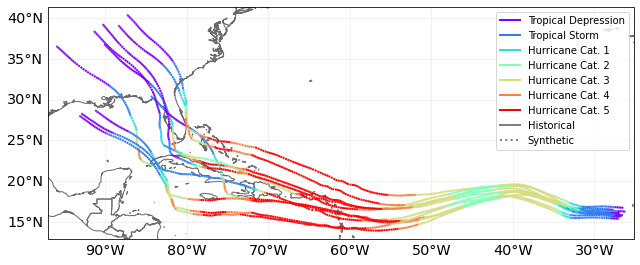

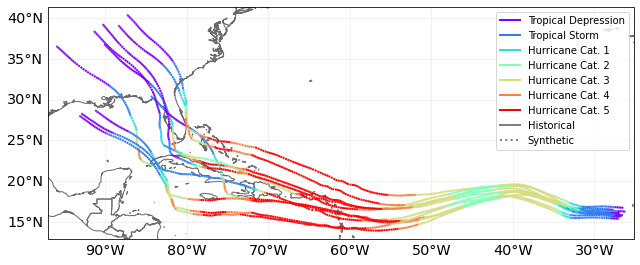

In [80]:
# create copy of original track set to apply the calc_perturbed_trajectories function to
import copy as cp
tracks_WP_proba = cp.deepcopy(tracks_WP)

# rest of your code goes here
range_max_shift_ini = np.linspace(0.5,10,2)
range_max_ddirection = np.pi/np.arange(180,520,140)
print (range_max_shift_ini)
print(range_max_ddirection)
for i in range_max_ddirection:
    irma = TCTracks()
    irma.read_ibtracs_netcdf(storm_id = '2017242N16333')
    irma.equal_timestep(time_step_h=1)
    irma.calc_perturbed_trajectories(nb_synth_tracks=9,max_shift_ini=0.75,max_dspeed_rel=0.3)
    print('calc done')
    irma.plot()
tracks_WP_proba.calc_perturbed_trajectories(nb_synth_tracks=9,max_shift_ini=0.75,max_dspeed_rel=0.3)

In [81]:
irma.get_track('2017242N16333')

<xarray.Dataset>
Dimensions:                 (time: 349)
Coordinates:
  * time                    (time) datetime64[ns] 2017-08-30 ... 2017-09-13T1...
    lon                     (time) float64 -26.9 -27.13 -27.36 ... -90.0 -90.1
    lat                     (time) float64 16.1 16.12 16.13 ... 36.6 36.7 36.8
Data variables:
    time_step               (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    radius_max_wind         (time) float64 60.0 60.0 60.0 ... 60.0 60.0 60.0
    radius_oci              (time) float64 180.0 180.0 180.0 ... 350.0 350.0
    max_sustained_wind      (time) float64 30.0 30.67 31.33 ... 15.0 15.0 15.0
    central_pressure        (time) float64 1.008e+03 1.008e+03 ... 1.005e+03
    environmental_pressure  (time) float64 1.012e+03 1.012e+03 ... 1.008e+03
    basin                   (time) <U2 'NA' 'NA' 'NA' 'NA' ... 'NA' 'NA' 'NA'
    on_land                 (time) bool False False False ... True True True
    dist_since_lf           (time) float64 nan nan nan ... 1.475e+03 1.49e+03
Attributes:
    max_sustained_wind_unit:  kn
    central_pressure_unit:    mb
    name:                     IRMA
    sid:                      2017242N16333
    orig_event_flag:          True
    data_provider:            ibtracs_mixed:lat(official_3h),lon(official_3h)...
    id_no:                    2017242016333.0
    category:                 5

In [82]:
# code part
help(TropCyclone)

Help on class TropCyclone in module climada.hazard.trop_cyclone:

class TropCyclone(climada.hazard.base.Hazard)
 |  TropCyclone(pool=None)
 |  
 |  Contains tropical cyclone events.
 |  
 |  Attributes
 |  ----------
 |  category : np.array(int)
 |      for every event, the TC category using the
 |      Saffir-Simpson scale:
 |          -1 tropical depression
 |           0 tropical storm
 |           1 Hurrican category 1
 |           2 Hurrican category 2
 |           3 Hurrican category 3
 |           4 Hurrican category 4
 |           5 Hurrican category 5
 |  basin : list(str)
 |      basin where every event starts
 |      'NA' North Atlantic
 |      'EP' Eastern North Pacific
 |      'WP' Western North Pacific
 |      'NI' North Indian
 |      'SI' South Indian
 |      'SP' Southern Pacific
 |      'SA' South Atlantic
 |  
 |  Method resolution order:
 |      TropCyclone
 |      climada.hazard.base.Hazard
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(se

### Questions

**1.a) What is the effect of max_shift_ini and max_ddirection on your storm tracks?**

Your short answer (2-5 sentences) goes here:

The max_shift it cause the enture trajectory to shif in the same direction. Max_direction determines the angle that influence if the pertubed trajectories are closer to each other.


**1.b) Which parameter set (nb_synth_tracks, max_shift_ini, max_dspeed_rel) have you chosen and why?** <br>
Note: There is no right or wrong answer to this question as long as you provide some rationale that justifies your choices (e.g. through literature values or common sense).

Your short answer (2-5 sentences) goes here: 

The selected values are max_shift_in is 0.75 and max_dspeed_rel is 0.35 this is because during the simulation, the chosen values produce a realistic results. However, using large number/value cause an artificial storm in other locations where the conditions are not known.

### Generate a hazard event set 
As a ﬁnal step of the hazard generation, we need to compute the 2D windfield of the storms tracks at the locations of interest. These locations are represented by the class `Centroids`. Familiarize yourself with the `TropCyclone` class and the function `set_from_tracks()`. <br>
<br>
This function applies the gradient wind model expressed in equation (4) (combined with equation (6)) from

    Holland, G.J. (1980): An Analytic Model of the Wind and Pressure Profiles in Hurricanes.
    Monthly Weather Review 108(8): 1212–1218.

More precisely, this function implements the following equation:

    V(r) = sqrt[(B/rho) * (r_max/r)^B * (penv - pcen) * e^(-(r_max/r)^B) + (r*f/2)^2] + (r*f/2)     (1)


In terms of this function's arguments, `B` is the Holland's b parameter at each track node and `r` is the distance between centroids and track nodes. The air density `rho` is assumed to be constant while the Coriolis parameter `f` is computed from the latitude `lat` using the constant rotation rate of the earth. `r_max` is the radius of maximum winds at each track node, `penv` is the environmental pressure at each track node, and `pcen` the central pressure at each track node.

Create the centroids using the following code:

2022-06-08 16:39:48,059 - climada.hazard.centroids.centr - WARNING - The use of Centroids.set_lat_lon is deprecated. Use Centroids.from_lat_lon instead.


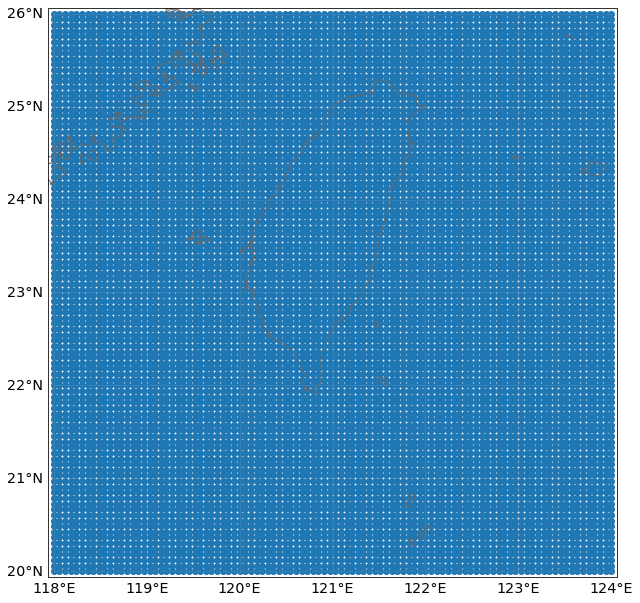

In [83]:
# construct centroids
min_lat, max_lat, min_lon, max_lon = 20, 26, 118, 124
resol = 100
cent = Centroids()
grid = (np.mgrid[min_lat : max_lat : complex(0, resol),
min_lon : max_lon : complex(0, resol)]). \
reshape(2, resol*resol).transpose()
cent.set_lat_lon(grid[:,0], grid[:,1])
cent.id = np.arange(cent.lat.size)
cent.check()
cent.plot();

Then create the tropical cyclone hazard information using the centroids and your track sets (original and probabilistic). <br>
*Note, this step takes some time (**> 10 minutes**). Calculating windfields is computationally demaning, especially for the probabilistically extended track set. Grab a coffee, sit back and relax.*

2022-06-08 16:39:50,703 - climada.hazard.trop_cyclone - WARNING - The use of TropCyclone.set_from_tracks is deprecated.Use TropCyclone.from_tracks instead.


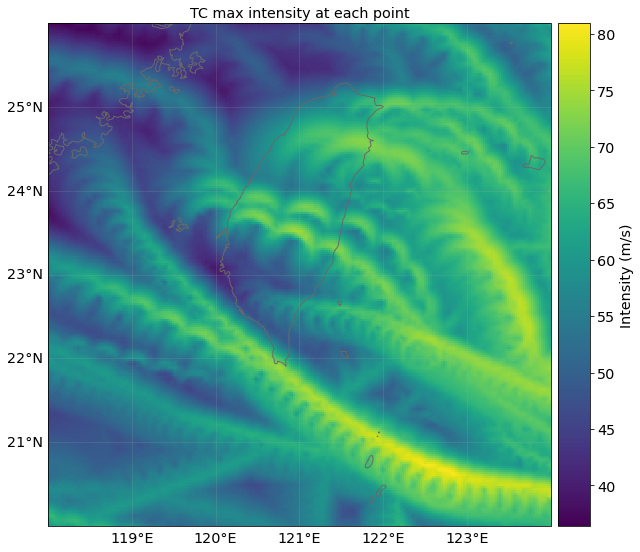

In [84]:
tc_WP = TropCyclone()
tc_WP.set_from_tracks(tracks_WP, centroids=cent)
tc_WP.check()
tc_WP.plot_intensity(event=0);

2022-06-08 16:41:21,946 - climada.hazard.trop_cyclone - WARNING - The use of TropCyclone.set_from_tracks is deprecated.Use TropCyclone.from_tracks instead.


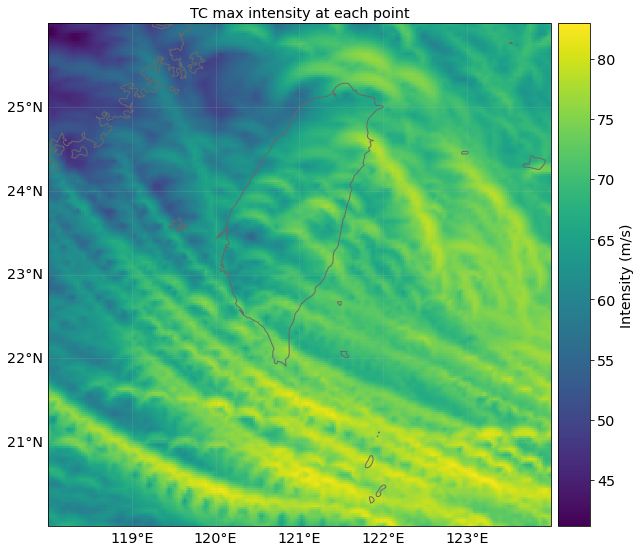

In [85]:
tc_WP_proba = TropCyclone()
tc_WP_proba.set_from_tracks(tracks_WP_proba, centroids=cent)
tc_WP_proba.check()
tc_WP_proba.plot_intensity(event=0);

Use the following routine to check the wind speeds of the hazard event set computed with the parameterization:

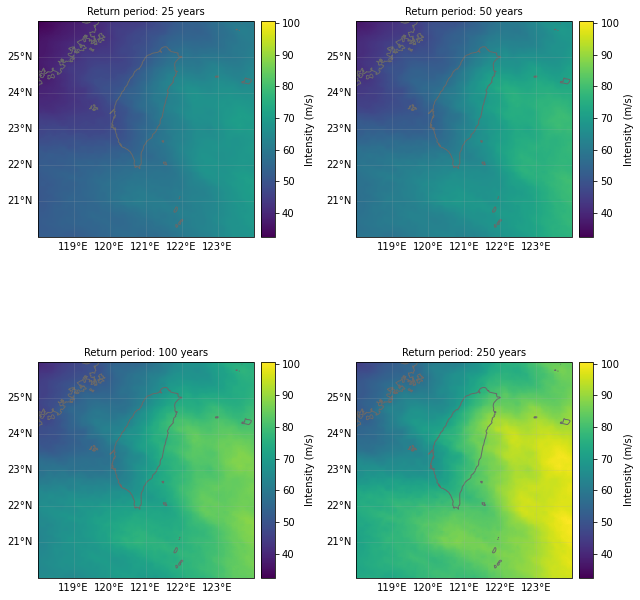

In [86]:
tc_WP_proba.plot_rp_intensity();

### Questions:

**1.c) What are centroids?**

Centroid defines the location of interest, and in our case is the Taiwan (Western Pacific).

**1.d) In the output graph of plot_rp_intensity: What is a 25-yr intensity?**

Your short answer (2-5 sentences) goes here: 

The 25-yr intensity is a maximum storm intensity which is expected to be produced at the centroid. The intensity is calculated by using WCTracks' data.

A note on saving time and for the next exercise block: <br>Instead of re-creating the hazard in each python session, you can save the calculated hazard to an hdf5 file with the method write_hdf5():

In [87]:
#tc_WP.write_hdf5(data_dir.joinpath('tc_WP.hdf5'))

tc_WP.write_hdf5('data_climada\tc_WP.hdf5')
tc_WP_proba.write_hdf5('data_climada\tc_WP_proba.hdf5')

In [88]:
import pandas as pd

df_hist = pd.DataFrame()
df_hist['category'] = tc_WP.category
df_prob = pd.DataFrame(tc_WP_proba.category)
df_prob['category'] = tc_WP_proba.category

df_hist.to_csv('data_climada\hist_cat.csv')
df_prob.to_csv('data_climada\prob_cat.csv')



and read it from the file next time with read_hdf5():

tc_WP = TropCyclone()
tc_WP.read_hdf5('data_climada\tc_WP.hdf5')

In [89]:
tc_WP = TropCyclone()
tc_WP.read_hdf5('data_climada\tc_WP.hdf5')

2022-06-08 16:58:35,949 - climada.hazard.base - WARNING - The use of Hazard.read_hdf5 is deprecated.Use Hazard.from_hdf5 instead.


Make sure to save the hazard file you just generated. You'll need it in the next exercise block for the next steps in the impact calculation.